# Preamble

In [33]:
using LinearAlgebra, ForwardDiff, DifferentialEquations, Plots, Roots
default(framestyle=:box, guidefont=font(14), titlefont=font(14), tickfont=font(12), 
    legend_font=font(12), legend=false, linewidth=3, linestyle=:auto);

In [3]:
Threads.nthreads()

10

In [5]:
lambda = 0.01;
xiG = 0;
xig = 4089;
alpha = (3e+4)^2/3;

n = 5;
xn = 4;

In [7]:
function metric(x)
    metric = zeros(eltype(x), n, n)
    
    xr2 = sum([x[i]^2 for i=1:xn])
    
    for i=1:xn, j=1:xn
        metric[i,j] = exp(-sqrt(2/3)*x[5])*(==(i,j) - 6*xiG^2*x[i]*x[j]/(1+xiG*xr2)) 
    end 
        
    metric[n,n] = 1
    
    return metric
end;

function viel(x)
    e,u = eigen(inv(metric(x)))
    return u*Diagonal([sqrt(ee) for ee in e])*inv(u)
end;

function gijk(x)
    metricdiff = ForwardDiff.jacobian(metric, x)
    gijk = [metricdiff[(i-1)*5+j,k] for i=1:n, j=1:n, k=1:n]
    return gijk
end;

function gijkl(x) 
    gijkl = zeros(eltype(x),n,n,n,n)
    
    for i=1:n, j=1:n
        gij(x) = metric(x)[i,j]
        gijhess = ForwardDiff.hessian(gij, x)
        
        for k=1:n, l=1:n
            gijkl[i,j,k,l] = gijhess[k,l]
        end;
    end;

    return gijkl
end;

function invgijk(x)
    invmetric = inv(metric(x))
    metricdiff = gijk(x)
    
    return [-invmetric[i,:]' * metricdiff[:,:,k] * invmetric[j,:] for i=1:n, j=1:n, k=1:n]
end;

function affine(x)
    invmetric = inv(metric(x))
    metricdiff = gijk(x)
    
    return [1/2*sum([invmetric[i,s]*(metricdiff[s,j,k] + metricdiff[s,k,j] - 
                    metricdiff[k,j,s]) for s=1:n]) for i=1:n, j=1:n, k=1:n]
end;

function Gammaijkl(x)
    invmetric = inv(metric(x))
    metricdiff = gijk(x)
    invgdiff = invgijk(x)
    ghess = gijkl(x)
    
    return [1/2*
        sum([invgdiff[i,s,l] * (metricdiff[s,j,k] + metricdiff[s,k,j] - metricdiff[k,j,s]) +
                invmetric[i,s]*(ghess[s,j,k,l] + ghess[s,k,j,l] - ghess[k,j,s,l]) 
                for s=1:n]) for i=1:n, j=1:n, k=1:n, l=1:n]
end;
    
function riemann(x)
    affinediff = Gammaijkl(x)
    Gamma = affine(x)
    
    return [affinediff[i,j,l,k] - affinediff[i,j,k,l] +
        sum([Gamma[s,j,l]*Gamma[i,k,s] - Gamma[s,j,k]*Gamma[i,l,s] for s=1:n]) 
        for i=1:n, j=1:n, k=1:n, l=1:n]
end;

function potU(x)
    xr2 = sum([x[i]^2 for i=1:xn])
    
    return lambda/4*exp(-2*sqrt(2/3)*x[5])*xr2^2 + 
        1/4/alpha*(1-exp(-sqrt(2/3)*x[5])*(1+(xig+xiG)*xr2))^2
end;

Ui(x) = ForwardDiff.gradient(potU,x);

function Uij(x)
    invmetric = inv(metric(x))
    Gamma = affine(x)
    Up = Ui(x)
    Uhess = ForwardDiff.hessian(potU,x)
    
    return Uhess - [sum([Gamma[k,i,j]*Up[k] for k=1:n]) for i=1:n, j=1:n]
end;

kin(x,p) = 1/2*p'*inv(metric(x))*p;

Hubble(x,p) = sqrt((kin(x,p) + potU(x))/3);

eH(x,p) = kin(x,p)/Hubble(x,p)^2;

M2PQ(x,p) = p*p'/2/Hubble(x,p);

function M2QQ(x,p)
    gdd = metric(x)
    guu = inv(gdd)
    Ruddd = riemann(x)
    Ud = Ui(x)

    M2QQ = Uij(x)
    
    for i=1:n, j=1:n
        M2QQ[i,j] += (-sum([Ruddd[a,b,c,j]*gdd[i,a]*guu[b,B]*p[B]*guu[c,C]*p[C] for a=1:n, b=1:n, c=1:n, B=1:n, C=1:n]) +
            (Ud[i]*p[j]+p[i]*Ud[j])/2 + 3*p[i]*p[j]/2)
    end

    return M2QQ
end;

# Background

In [9]:
function bgEoM(du, u, params, t) # u[1:n] = phi, u[n+1:2n] = pi, u[2n+1] = N
    x = u[1:n]
    p = u[n+1:2*n]
    H = Hubble(x,p)
    invmetric = inv(metric(x))
    Gamma = affine(x)
    Up = Ui(x)
    
    for i=1:n
        du[i] = (invmetric*p)[i]
        du[i+n] = p'*Gamma[:,i,:]*du[1:n] - 3*H*p[i] - Up[i]
    end;
    
    du[2*n+1] = H;
end;

ui = [0.08,0,0,0,4,0,0,0,0,0,0];
Hi = Hubble(ui[1:n],ui[n+1:2*n]);
tf = 50/Hi;
tspan = (0,tf);

bgprob = ODEProblem(bgEoM,ui,tspan,0);
@time bgsol = solve(bgprob,Tsit5(),reltol=1e-10,abstol=1e-10);

 23.055555 seconds (374.23 M allocations: 15.074 GiB, 3.47% gc time, 6.13% compilation time)


In [35]:
x1list = [bgsol[i][1] for i=1:length(bgsol.t)];
ylist = [bgsol[i][5] for i=1:length(bgsol.t)];
Nlist = [bgsol[i][11] for i=1:length(bgsol.t)];
Hlist = [Hubble(bgsol[i][1:5],bgsol[i][6:10]) for i=1:length(bgsol.t)];
eHlist = [eH(bgsol[i][1:5],bgsol[i][6:10]) for i=1:length(bgsol.t)];
aHlist = [exp(Nlist[i])*Hlist[i] for i=1:length(bgsol.t)];

x1sol(t) = bgsol(t)[1];
ysol(t) = bgsol(t)[5];

xsol(t) = bgsol(t)[1:n];
psol(t) = bgsol(t)[n+1:2*n];
Nsol(t) = bgsol(t)[11];
Hsol(t) = Hubble(bgsol(t)[1:5],bgsol(t)[6:10]);

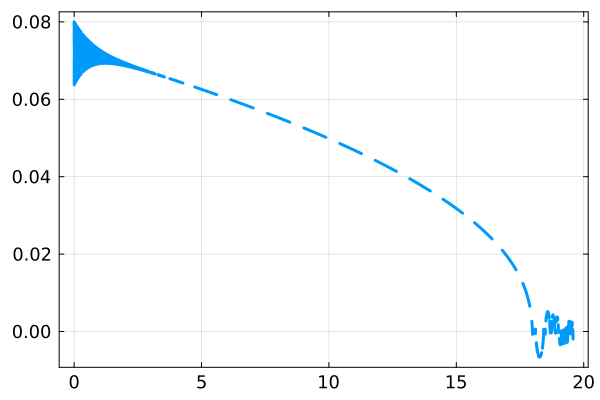

In [11]:
plot(Nlist,x1list)

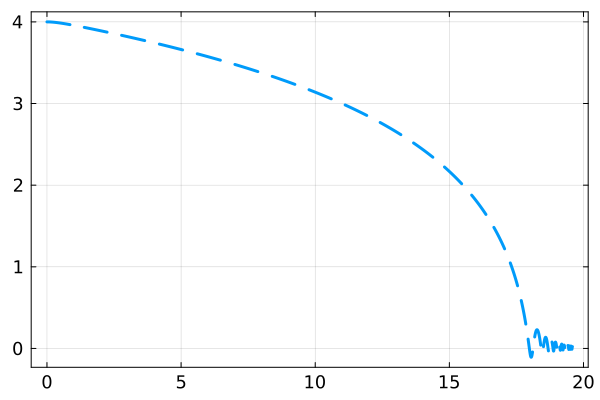

In [12]:
plot(Nlist,ylist)

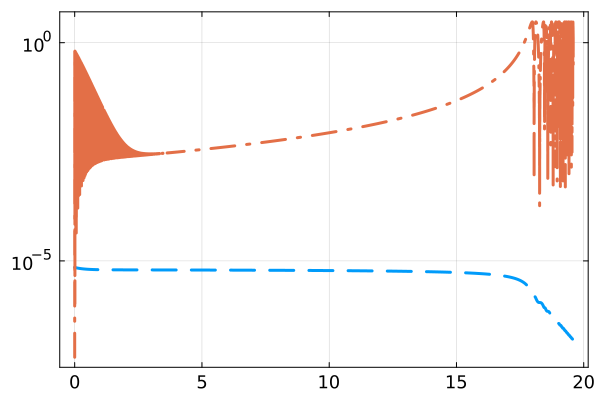

In [13]:
plot(Nlist,Hlist,yscale=:log10)
plot!(Nlist[2:end],eHlist[2:end])

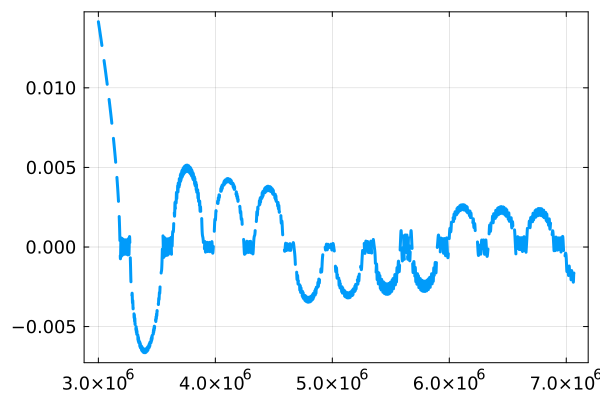

In [14]:
tzoom = [t for t in bgsol.t if 3e+6 < t];
plot(tzoom,map(x1sol,tzoom))

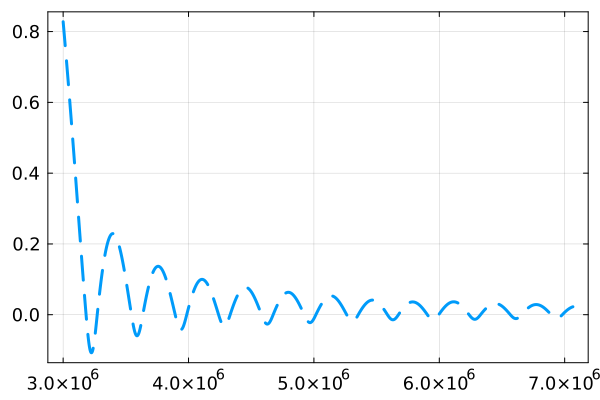

In [15]:
plot(tzoom,map(ysol,tzoom))

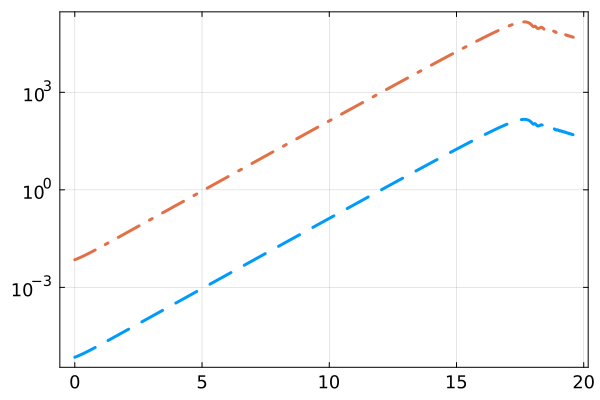

In [16]:
plot(Nlist,aHlist,yscale=:log10)
plot!(Nlist,1000*aHlist,yscale=:log10)

# Perturbation

In [53]:
function ptbEoM(du, u, params, t) # u[1+n(alpha-1):n+n(alpha-1)] = Q, u[n^2+1+n(alpha-1):n^2+n+n(alpha-1)] = P, params[1] = k
    x = xsol(t)
    p = psol(t)
    k = params[1]
    a = exp(Nsol(t))

    H = Hubble(x,p)
    gdd = metric(x)
    guu = inv(gdd)
    Gamma = affine(x)

    M2PQs = M2PQ(x,p)
    M2QQs = M2QQ(x,p)
    
    for alpha=1:n
        Q = u[1+n*(alpha-1):n+n*(alpha-1)]
        P = u[n^2+1+n*(alpha-1):n^2+n+n*(alpha-1)]
    
        for i=1:n
            du[i+n*(alpha-1)] = -p'*guu*Gamma[i,:,:]*Q + (guu*P)[i] + (guu*M2PQs*Q)[i]
            du[i+n^2+n*(alpha-1)] = P'*Gamma[:,i,:]*guu*p - 3*H*P[i] - k^2/a^2*(gdd*Q)[i] - (M2QQs*Q)[i] - (M2PQs*guu*P)[i]
        end
    end
end;

#ui = [0.08,0,0,0,4,0,0,0,0,0,0];
#Hi = Hubble(ui[1:n],ui[n+1:2*n]);
#tf = 50/Hi;
#tspan = (0,tf);

#bgprob = ODEProblem(bgEoM,ui,tspan,0);
#@time bgsol = solve(bgprob,Tsit5(),reltol=1e-10,abstol=1e-10);

In [ ]:
qq = 0.1;
Hcross(t) = 1000*exp(Nsol(t))*Hsol(t) - qq;
ti = find_zero(Hcross, 1);
Qi(t) = 1/(exp(Nsol(t))*sqrt(2*qq))*viel(xsol(t))*exp(im*qq*t/exp(Nsol(t)));
function Pi(t) 
    x = xsol(t)
    p = psol(t)
    gdd = metric(x)
    guu = inv(gdd)
    Gamma = affine(x)
    QQ = Qi(t)
    
    DQi = ForwardDiff.derivative(Qi,t)
    for i=1:n, alpha=1:n
        DQi[i,alpha] += p'*guu*Gamma[i,:,:]*QQ[:,alpha]
    end
    
    return gdd*DQi
end;

QPi = vcat(vec(Qi(ti)),vec(Pi(ti)));
ptbprob = ODEProblem(ptbEoM,QPi,(ti,tf),[qq]);
@time ptbsol = solve(ptbprob,Tsit5(),reltol=1e-10,abstol=1e-10);